In [1]:
import mici
import sde.mici_extensions as mici_extensions
import sde.sympy_helpers as sympy_helpers
import sympy as sym
import numpy as onp
from jax.config import config
config.update("jax_enable_x64", True)
import jax.numpy as np
import jax.lax as lax
import jax.api as api
import matplotlib.pyplot as plt
import arviz
import corner

## Diffusion model

We consider the hypoelliptic diffusion defined by the system of *stochastic differential equations* (SDEs)

$$
  \underbrace{\begin{bmatrix} \mathrm{d} \mathsf{x}_1(\tau) \\ \mathrm{d} \mathsf{x}_2(\tau) \end{bmatrix}}_{\mathrm{d}\mathsf{x}(\tau)} = 
  \underbrace{\begin{bmatrix}
    \frac{1}{\epsilon} (\mathsf{x}_1(\tau) - \mathsf{x}_1(\tau)^3 - \mathsf{x}_2(\tau)) \\
    \gamma \mathsf{x}_1(\tau) - \mathsf{x}_2(\tau) + \beta
  \end{bmatrix}}_{a(\mathsf{x}(\tau),\mathsf{z})} \mathrm{d} \tau + 
  \underbrace{\begin{bmatrix} 0 \\ \sigma \end{bmatrix}}_{B(\mathsf{x}(\tau),\mathsf{z})} \mathrm{d} \mathsf{w}(\tau)
$$
with $\mathsf{x}$ the $\mathcal{X} = \mathbb{R}^2$-valued diffusion process of interest, $\mathsf{w}$ a univariate Wiener process and $\mathsf{z} = [\sigma;\epsilon;\gamma;\beta] \in \mathcal{Z} =\mathbb{R}_{>0} \times \mathbb{R}_{>0} \times \mathbb{R} \times \mathbb{R}$ the model parameters. 

This SDE system corresponds to a stochastic variant of the Fitzhugh-Nagumo model, a simplified description of actional potential generation within a neuronal axon.

We will use *SymPy* to symbolically define the drift $a$ and diffusion coefficient $B$ for the model in terms of the current state $\mathsf{x}$ and parameters $\mathsf{z} = [\sigma;\epsilon;\gamma;\beta]$. This will later allow us to automatically construct a function to numerical integrate the SDE system.

In [2]:
x = sympy_helpers.SymbolTuple('x', 2)
σ, ε, δ = sym.symbols('σ ε δ', real=True, positive=True)
γ, β = sym.symbols('γ β', real=True)
z = (σ, ε, γ, β)
a = sym.Matrix(((x[0] - x[0]**3 - x[1]) / ε, γ * x[0] - x[1] + β))
B = sym.Matrix((0, σ))

## Time discretisation

As in general exact simulation of the diffusion models of interest will be intractable, we define an approximate discrete time model based on numerical integration of the SDEs. Various numerical schemes for integrating SDE systems are available with varying convergence properties and implementational complexity - see for example [*Numerical Solutions of Stochastic Differential Equations* (Kloden and Platen, 1992)](https://books.google.com.sg/books/about/Numerical_Solution_of_Stochastic_Differe.html?id=7bkZAQAAIAAJ&source=kp_book_description&redir_esc=y) for an in-depth survey.

The simplest and most common scheme is the *Euler-Maruyama* method (corresponding to a strong-order 0.5 Taylor approximation), which for a small time step $\delta > 0$ can be defined by a *forward operator* $f_{\delta} : \mathcal{Z} \times \mathcal{X} \times \mathcal{V} \to \mathcal{X}$

$$
  \newcommand{\vct}[1]{{#1}}
  \newcommand{\mtx}[1]{{#1}}
  \vct{f}_\delta(\vct{z}, \vct{x}, \vct{v}) = 
  \vct{x} + \delta \vct{a}(\vct{x}, \vct{z}) + 
  \delta^\frac{1}{2} \mtx{B}(\vct{x},\vct{z}) \vct{v}.
$$

The corresponding single step update can be defined using SymPy as:

In [3]:
def euler_maruyama_step(x, v, δ, a, B):
    return sym.Array(x + δ * a + δ**0.5 * B * v).reshape(a.shape[0])

More accurate approximations can be derived by using higher-order terms from the stochastic Taylor expansion of the SDE system. For example for a SDE model with *additive noise*, i.e. a diffusion coefficient $B$ which is independent of the state, a *strong order 1.5 Taylor scheme* can be defined by the forward operator

$$
  \newcommand{\vct}[1]{{#1}}
  \newcommand{\mtx}[1]{{#1}}
  \vct{f}_\delta(\vct{z}, \vct{x}, \vct{v}) = 
  \vct{x} + \delta \vct{a}(\vct{x}, \vct{z}) + 
  \frac{\delta^2}{2} \left(
    \partial_1 \vct{a}(\vct{x},\vct{z}) \vct{a}(\vct{x}, \vct{z}) + 
    [(\mathrm{tr}(\partial^2_1 a_i(\vct{x}, \vct{z}) \mtx{B}(\vct{z}) \mtx{B}(\vct{z})^{\rm T}))_i]
  \right) +
  \begin{bmatrix} 
    \frac{\sqrt{3}\delta^\frac{1}{2}}{2} \mtx{B}(\vct{z}) + \frac{\sqrt{3}\delta^\frac{3}{2}}{3} \partial_1\vct{a}(\vct{x},\vct{z})\mtx{B}(\vct{z}) & 
    \frac{\delta^\frac{1}{2}}{2} \mtx{B}(\vct{z}) 
  \end{bmatrix}
  \vct{v}
$$

and this can be implemented using SymPy as follows

In [4]:
def strong_order_1p5_step(x, v, δ, a, B):
    step_mean = (
        sym.Matrix(x) + δ * a + 
        (δ**2 / 2) * a.jacobian(x) * a + 
        (δ**2 / 2) * sym.Matrix(
            [sym.trace(sym.hessian(a[i], x) * (B * B.T)) 
             for i in range(a.shape[0])])
    )
    step_sqrt_covar = sym.Matrix.hstack(
        -sym.sqrt(3) * δ**0.5 * ((B / 2) + δ * a.jacobian(x) * B / 3), 
        δ**0.5 * B / 2
    )
    return sym.Array(step_mean + step_sqrt_covar * sym.Matrix(v)).reshape(a.shape[0])

We can use these symbolically defined single step updates to define corresponding numerical functions which take NumPy arrays as inputs using SymPy's [code-generation](https://docs.sympy.org/latest/modules/utilities/codegen.html) functionality. Here we use a helper function defined in the `sde.sympy_helpers` module which also performs [common subexpression elimination](https://docs.sympy.org/latest/modules/rewriting.html#module-sympy.simplify.cse_main) and allows calling NumPy API functions from an alternative NumPy-like package, with we here using [JAX](https://github.com/google/jax) as this will allow us to later automatically construct efficient derivative functions for inference.

In [5]:
v = sympy_helpers.SymbolTuple('v', B.shape[1] * 2)
x_n = strong_order_1p5_step(x, v, δ, a, B)
forward_op_func = sympy_helpers.generate_func(
    (x, v, δ, *z), x_n, 'forward_op_func', numpy_module=np)

## Generative model

As described in the paper we use a non-centered parameterisation of the generative model for the time-discretised diffusion $\mathsf{x}_{1{:}\mathtt{ST}}$.

We use priors $\mathsf{x}_{0} \sim \mathcal{N}([-0.5;-0.5], \mathbb{I}_2)$, $\log{\sigma} \sim \mathcal{N}\left(-1, 0.5^2\right)$, $\log{\epsilon} \sim \mathcal{N}\left(-2, 0.5^2\right)$, ${\gamma} \sim \mathcal{N}\left(1, 0.5^2\right)$ and ${\beta} \sim \mathcal{N}\left(1, 0.5^2\right)$ which were roughly tuned so that with high probability state sequences $\mathsf{x}_{1{:}\mathtt{ST}}$ generated from the prior exhibited stable spiking dynamics and such that $\sigma$ and $\epsilon$ obey their positivity constraints. 

The parameter and initial state generator functions were set to $g_{\mathsf{z}}(u) = [\exp(0.5 u_1 -1); \exp(0.5 u_2 - 2); 0.5 u_3 + 1; 0.5 u_4 + 1]$ and $g_{\mathsf{x}_0}(\vct{v}_0, \vct{z}) = [v_{0,1} -0.5; v_{0,2} - 0.5]$ with input distributions $\tilde{\mu} = \mathcal{N}(\vct{0},\mathbb{I}_4)$ and $\tilde{\nu} = \mathcal{N}(\vct{0},\mathbb{I}_2)$.

In [6]:
def generate_params(u):
    return {
        'σ': np.exp(0.5 * u[0] - 1),
        'ε': np.exp(0.5 * u[1] - 2),
        'γ': 0.5 * u[2] + 1,
        'β': 0.5 * u[3] + 1,
    }

def generate_init_state(v_0):
    return np.array([-0.5, -0.5]) + v_0

The overall generative model for $\mathsf{x}_{1{:}\mathtt{ST}}$ can then be summarised

\begin{align}
  \mathsf{u} &\sim \mathcal{N}(0, \mathbb{I}_4) \\
  \mathsf{v}_0 &\sim \mathcal{N}(0, \mathbb{I}_2) \quad \forall \mathtt{s} \in 0{:}\mathtt{ST}\\
  \mathsf{z} &= g_{\mathsf{z}}(\mathsf{u})\\
  \mathsf{x}_0 &= g_{\mathsf{x}_0}(\mathsf{v}_0) \\
  \mathsf{x}_{\mathtt{s}+1} &= f_{\delta}(\mathsf{z}, \mathsf{x}_{\mathtt{s}}, \mathsf{v}_{\mathtt{s}})
  \quad \forall \mathtt{s} \in 1{:}\mathtt{ST}
\end{align}

This can be implemented using the just defined generator and forward operator functions and the JAX [`scan`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html) operator as follows

In [8]:
def generate_x_seq(q, delta, dim_state, num_param, dim_noise):
    u, v_0, v_r = np.split(q, (num_param, num_param + dim_state))
    params = generate_params(u)
    x_init = generate_init_state(v_0)
    v_seq = np.reshape(v_r, (-1, dim_noise))

    def step_func(x, v):
        x_n = forward_op_func(x, v, delta, **params)
        return (x_n, x_n)

    _, x_seq = lax.scan(step_func, x_init, v_seq)

    return x_seq, params, x_init

## Simulated observed data

We assume the $\mathtt{Y} = 1$ dimensional observations $\mathsf{y}_{1{:}\mathtt{T}}$ correspond to direct observation of the first state component i.e. $h_\mathtt{t}(x) = x_1 ~~\forall \mathtt{t} \in 1{:}\mathtt{T}$

In [7]:
def obs_func(x_seq):
    return x_seq[..., 0:1]

In [9]:
num_param = len(z)
dim_state = len(x)
dim_noise = len(v)
num_obs = 100
obs_interval = 0.5
num_steps_per_obs = 25
num_steps = num_obs * num_steps_per_obs
dim_q = num_param + dim_state + num_obs * num_steps_per_obs * dim_noise
delta = obs_interval / num_steps_per_obs
obs_indices = (1 + np.arange(num_obs)) * num_steps_per_obs - 1

/home/matt/miniconda3/envs/jax-latest/lib/python3.7/site-packages/jax/lib/xla_bridge.py:114: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [10]:
seed = 20190412
rng = onp.random.RandomState(seed)

In [11]:
q_ref = rng.standard_normal(size=dim_q)

In [12]:
x_seq_ref, params_ref, x_init_ref = generate_x_seq(
    q_ref, delta, dim_state, num_param, dim_noise)
x_obs_seq_ref = x_seq_ref[obs_indices]
y_obs_seq_ref = obs_func(x_obs_seq_ref)

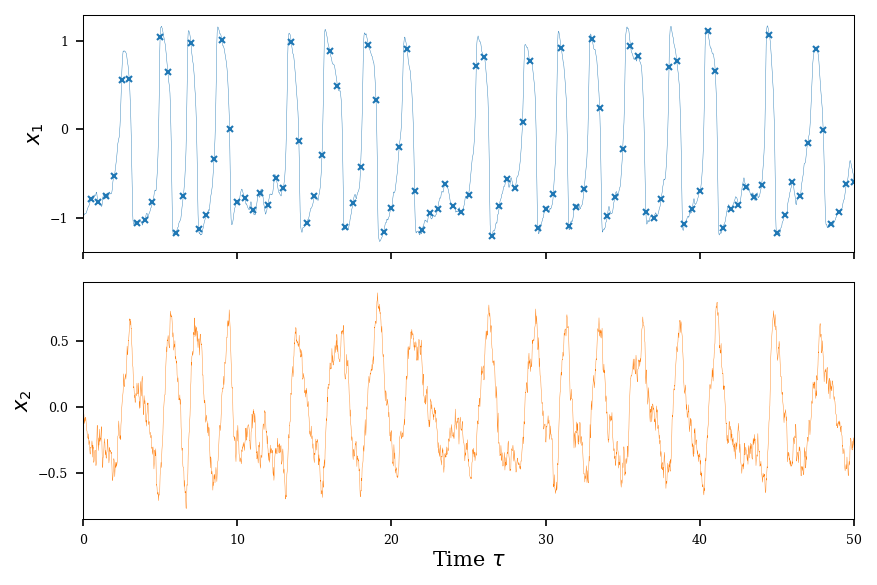

In [13]:
with plt.style.context('hidpi.mplstyle'):
    fig, axes = plt.subplots(2, sharex=True, figsize=(6, 4))
    t_seq = (1 + np.arange(num_steps)) * (num_obs) * obs_interval / num_steps
    axes[0].plot(t_seq, x_seq_ref[:, 0], lw=0.2, color='C0')
    axes[1].plot(t_seq, x_seq_ref[:, 1], lw=0.2, color='C1')
    axes[0].plot(t_seq[obs_indices], y_obs_seq_ref[:, 0], 'x', ms=3, color='C0')
    axes[0].set_ylabel('$x_1$')    
    axes[1].set_ylabel('$x_2$')
    for ax in axes:
        ax.set_xlim(0, num_obs * obs_interval)
    _ = axes[1].set_xlabel('Time $\\tau$')
    fig.tight_layout()

## Markov chain Monte Carlo approximate inference

In [ ]:
num_chains = 2
num_sample = 1000
num_warmup = 500
num_obs_per_block = 5
max_iters = 50
step_size = 3e-2
num_inner_step = 1
constraint_tol = 1e-8
init_reg_coeff = 2e-2
position_tol = 1e-8
max_tree_depth = 10

In [ ]:
metric = mici.matrices.IdentityMatrix(dim_q)
system = mici_extensions.ConditionedDiffusionConstrainedSystem(
    obs_interval, num_steps_per_obs, num_obs_per_block, y_obs_seq_ref, 
    num_param, dim_state, dim_noise, forward_op_func, generate_init_state, 
    generate_params, obs_func, metric)

In [ ]:
integrator = mici.integrators.ConstrainedLeapfrogIntegrator(
    system, step_size, num_inner_step, 
    retraction_solver=mici_extensions.retract_onto_manifold_quasi_newton, 
    reverse_check_tol=2 * position_tol, 
    retraction_solver_kwargs=dict(convergence_tol=constraint_tol, 
                                  position_tol=position_tol, 
                                  max_iters=max_iters))

In [ ]:
sampler = mici.samplers.HamiltonianMCMC(
    system, rng, 
    mici_extensions.SwitchPartitionTransitionWrapper(
        system,
        mici.transitions.MultinomialDynamicIntegrationTransition(
            system, integrator, max_tree_depth, 
            termination_criterion=mici_extensions.no_u_turn_criterion)
    )
)

In [ ]:
def generate_x_obs_seq_init(rng):
    return np.concatenate(
        (y_obs_seq_ref, rng.standard_normal(y_obs_seq_ref.shape) * 0.5), -1)

In [ ]:
init_states = [
    mici_extensions.get_initial_state(
        system, rng, generate_x_obs_seq_init, dim_q, constraint_tol, 
        reg_coeff=init_reg_coeff)
    for c in range(num_chains)]

In [ ]:
def trace_func(state):
    q = state.pos
    u, v_init, _ = onp.split(q, (num_param, num_param + dim_state,))
    params = generate_params(u)
    x_init = generate_init_state(v_init)
    return {'x_init': x_init, **params}

In [ ]:
final_states, traces, stats = sampler.sample_chains(
    num_sample + num_warmup, init_states, trace_funcs=[trace_func],
    monitor_stats=['accept_prob', 'convergence_error'],)

In [ ]:
with plt.style.context('hidpi.mplstyle'):
    fig, axes = plt.subplots(num_param, num_param, figsize=(1.5 * num_param, 1.5 * num_param))
    _ = corner.corner(
        np.stack([onp.concatenate([t[num_warmup:] for t in traces[param_name]]) 
                  for param_name in params_ref.keys()], -1),
        labels=[f'{param_name}' for param_name in params_ref.keys()],
        truths=list(params_ref.values()),
        color='C0', truth_color='C1', show_titles=True, smooth=0.75,
        fig=fig)
    for i in range(num_param):
        for j in range(i+1):
            if i != num_param - 1:
                axes[i, j].xaxis.set_ticks_position('none')
            if j != 0 or (i == j == 0):
                axes[i, j].yaxis.set_ticks_position('none')